In [2]:
import os
from dotenv import load_dotenv
import comet_ml
# from comet_ml import Experiment

import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.feature_selection import SelectFromModel, RFE

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve, CalibrationDisplay


In [3]:
load_dotenv('../.env')
COMET_API_KEY = os.getenv('COMET_API_KEY')
exp = comet_ml.Experiment(
    api_key=COMET_API_KEY,
    project_name='ift6758',
    workspace='meriembchaaben',
)
exp.set_name('Question6/YourBestShot')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/meriembchaaben/ift6758/40f60ec8dff54d7d86391cd703161bd0



In [4]:
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates

def compute_cumulative_goal_rate_per_percentile(probs, y):
        percentiles = []
        rates = []
        cum_rate = 0

        for i in range(0, 101):
            percentile = np.percentile(probs, i)
            goals = 0
            no_goals = 0
            for idx, p in enumerate(probs):
                if p<=percentile:
                    if y[idx]==1:
                        goals+=1
                    else:
                        no_goals+=1
            cum_rate += goals / (goals + no_goals)
            percentiles.append(percentile)
            rates.append(cum_rate)
        return percentiles, rates


def plot_metrics(pipe):
    random_clf = DummyClassifier(strategy="uniform").fit(X_train, y_train)
    random_probs = random_clf.predict_proba(X_val)[:, 1]
    y_val_pred = pipe.predict_proba(X_val)[:,1]

    ### ROC curve - AUC metric ###
    pipe_roc_auc = roc_auc_score(y_val, y_val_pred)
    random_auc = roc_auc_score(y_val, random_probs)
    print('Our Model: ROC AUC=%.3f' % (pipe_roc_auc))
    print('Random: ROC AUC=%.3f' % (random_auc))
    exp.log_metric('ROC AUC', pipe_roc_auc)
    xgb_fpr, xgb_tpr, _ = roc_curve(y_val, y_val_pred)
    plt.figure(figsize=(6, 6))
    plt.plot(xgb_fpr, xgb_tpr, marker='.', label=f'{params["classifier"]}')
    plt.plot([0, 1], [0, 1], linestyle='--', marker='.', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    exp.log_figure('ROC AUC Curve', plt)
    # plt.savefig('../figures/roc.png')
    plt.show()


    # The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile,
    # i.e. if a value is the 70th percentile, it is above 70% of the data. 
    ### goal_rate = F(shot probability model percentile) ###
    percentiles1, rates1 = compute_goal_rate_per_percentile(y_val_pred, y_val.to_numpy())
    percentiles2, rates2 = compute_goal_rate_per_percentile(random_probs, y_val.to_numpy())
    plt.figure(figsize=(6, 6))
    plt.plot(percentiles1, rates1, marker='.', label=f'{params["classifier"]}')
    plt.plot(percentiles2, rates2, marker='.', label='Random')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel('Goal rate')
    plt.legend()
    # plt.savefig('../figures/goal_rate_percentile_1.png')
    exp.log_figure('Goal Rate vs Predicted Percentile', plt)
    plt.show()


    # c. The cumulative proportion of goals (not shots) as a function of the shot probability model percentile.
    percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(y_val_pred, y_val.to_numpy())
    percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(random_probs, y_val.to_numpy())
    plt.figure(figsize=(6, 6))
    plt.plot(percentiles1, rates1, marker='.', label=f'{params["classifier"]}')
    plt.plot(percentiles2, rates2, marker='.', label='Random')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel('Goal rate')
    plt.legend()
    # plt.savefig('../figures/goal_rate_percentile_2.png')
    exp.log_figure('Cumulative Goal Rate vs Predicted Percentile', plt)
    plt.show()

    # d. The reliability diagram (calibration curve).
    fig, ax = plt.subplots(figsize=(6, 6))
    disp1 = CalibrationDisplay.from_estimator(pipe, X_val, y_val, label=f'{params["classifier"]}', ax=ax)
    disp4 = CalibrationDisplay.from_estimator(random_clf, X_val, y_val, label='Random', ax=ax)
    # plt.savefig('../figures/calibration_diagram.png')
    exp.log_figure('Reliability Diagram', plt)
    plt.show()

In [5]:
# Load Data
df = pd.read_csv('../data/M2Data/trainingSet.csv')
df['strength'] = df['strength2']

df['rebound'] = df.rebound.astype(int)
df['Goal'] = df['Goal'].astype(int)
df['EmptyNet'] = df['EmptyNet'].astype(int)

df = df.drop([
    'totalPlayTime', 'gameID', 'eventType',
    'lastEventPeriodTime',
    'strength',
    'lastEventAngle',
    'lastEventGameSeconds',
    'emptyNet',
    'lastEventPeriod',
    'xCoord', 'yCoord',
    'lastEventXCoord', 'lastEventYCoord',
    'index',
], 1, errors='ignore')



# Train / Valid Split
season_split = 2018
X, y = df.drop('Goal', 1), df['Goal']
train_ix, valid_ix = df[df.season < season_split].index, df[df.season >= season_split].index
X_train, X_val, y_train, y_val = X.iloc[train_ix], X.iloc[valid_ix], y.iloc[train_ix], y.iloc[valid_ix]

X_train.shape, X_train.columns, y_train.shape, y_train.name

exp.log_dataset_hash([X_train, X_val, y_train, y_val])
exp.log_dataset_info([X_train, X_val, y_train, y_val])

/var/folders/6f/p9hxltwx0_q2p94nbn_q4b4wsts63p/T/ipykernel_89438/1565161413.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop([
/var/folders/6f/p9hxltwx0_q2p94nbn_q4b4wsts63p/T/ipykernel_89438/1565161413.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X, y = df.drop('Goal', 1), df['Goal']
COMET WARNING: truncated string; too long: '[        period periodTime periodType        teamOfShooter homeOrAway  \
0            1      00:51    REGULAR  Toronto Maple Leafs       home   
1            1      01:05    REGULAR  Toronto Maple Leafs       home   
2            1      01:06    REGULAR  Toronto Maple Leafs       home   
3            1      01:53    REGULAR  Toronto Maple Leafs       home   
4            1      02:37    REGULAR  Toronto Maple Leafs       home   
...        ...        ...        ...   

In [6]:
def create_pipeline(params):
    encoder = params.get('encoder', 'OrdinalEncoder')
    feature_selection=params.get('feature_selection', None)
    n_features_to_select=params.get('n_features_to_select', 3)
    classifier=params.get('classifier', 'GaussianNB')

    # MLPClassifier
    hidden_layer_sizes=params.get('hidden_layer_sizes', (100,))
    early_stopping = params.get('early_stopping', True)

    # XGBoostClassifier
    max_depth = params.get('max_depth', 3)
    n_estimators = params.get('n_estimators', 3)
    use_label_encoder=params.get('use_label_encoder', False)

    encoder_map = {
        'OrdinalEncoder': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        'OneHotEncoder': OneHotEncoder(handle_unknown='ignore')
    }

    feature_selection_map = {
        'SelectFromModel_LinearSVC': SelectFromModel(LinearSVC(C=0.1, penalty="l1", dual=False)),
        'RFE_GaussianNB': RFE(GaussianNB(), n_features_to_select=n_features_to_select, step=1),
        'RFE_RandomForestClassifier': RFE(RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators), n_features_to_select=n_features_to_select, step=1),
        'RFE_XGBClassifier': RFE(XGBClassifier(max_depth=max_depth,n_estimators=n_estimators), n_features_to_select=n_features_to_select, step=1),
    }

    classifier_map = {
        'GaussianNB': GaussianNB(),
        'RandomForestClassifier': RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators),
        'XGBClassifier': XGBClassifier(
            max_depth=max_depth,
            n_estimators=n_estimators,
            use_label_encoder=use_label_encoder,
),
        'MLPClassifier': MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            early_stopping=early_stopping,
        ),
    }

    numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing Data')),
        ('encoder', encoder_map[encoder]),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, make_column_selector(dtype_include="number")),
            ("cat", categorical_transformer, make_column_selector(dtype_exclude="number")),
        ]
    )

    if feature_selection:
        feature_selection = [('feature_selection', feature_selection_map[feature_selection])]
    else:
        feature_selection = []

    pipe = Pipeline(steps=[('preprocessor', preprocessor)] + feature_selection + [('classifier', classifier_map[classifier])])
    
    return pipe

COMET WARNING: truncated string; too long: 'ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17f863940>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Missing '
                                                                           'Data',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                      

0.8942816670394393
Our Model: ROC AUC=0.652
Random: ROC AUC=0.500


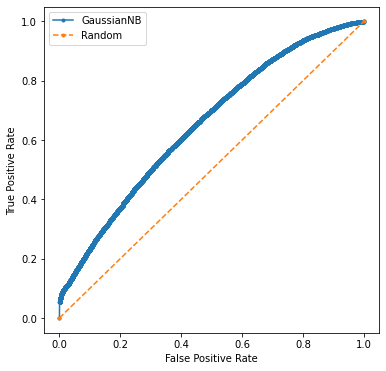

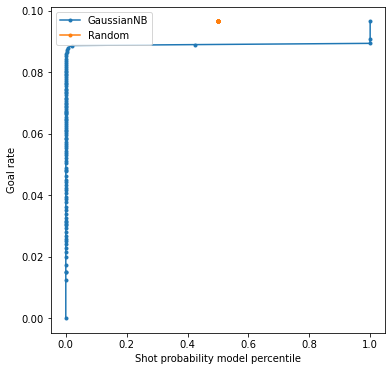

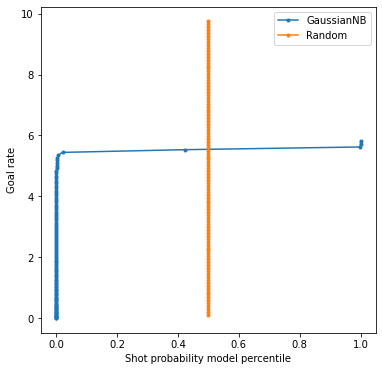

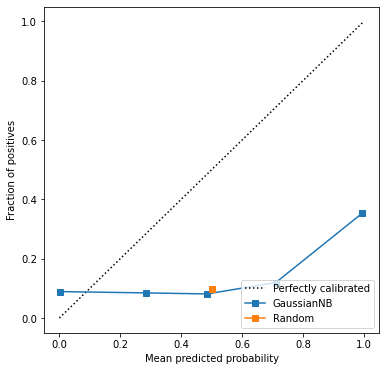

In [7]:
params = {
    'feature_selection': None,
    'classifier': 'GaussianNB',
}

exp.log_parameters(params)
pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_val, y_val))
exp.log_metric('Accuracy', pipe.score(X_val, y_val))
plot_metrics(pipe)


COMET WARNING: truncated string; too long: 'ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17f669d90>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Missing '
                                                                           'Data',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                      

0.8941822609905813
Our Model: ROC AUC=0.646
Random: ROC AUC=0.500


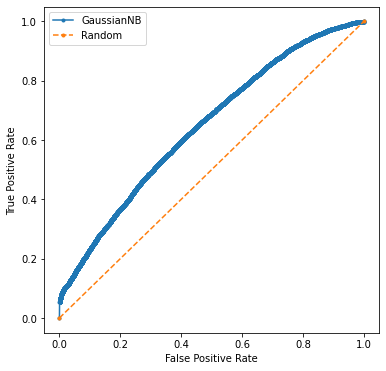

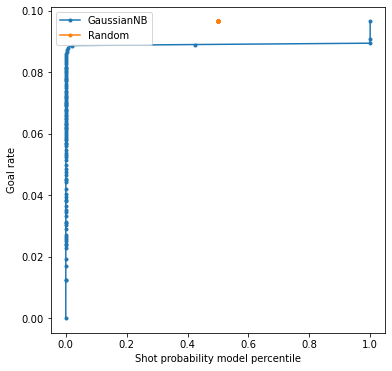

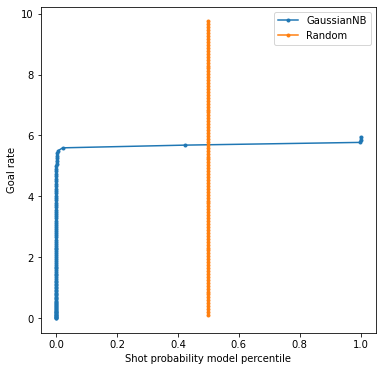

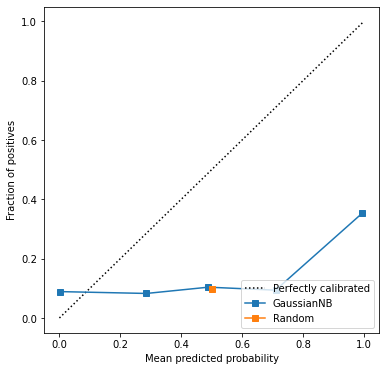

In [8]:
params = {
    'feature_selection': 'SelectFromModel_LinearSVC',
    'classifier': 'GaussianNB',
}

exp.log_parameters(params)
pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_val, y_val))
exp.log_metric('Accuracy', pipe.score(X_val, y_val))
plot_metrics(pipe)

0.9084967320261438
Our Model: ROC AUC=0.656


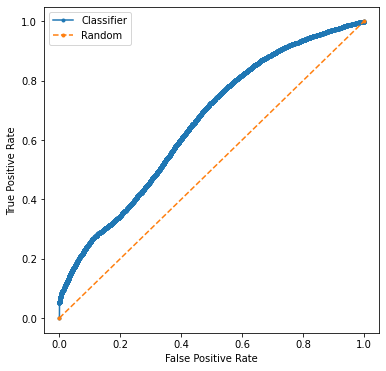

In [203]:
params = {
    'feature_selection': 'RFE_RandomForestClassifier',
    'n_features_to_select': 5,
    'classifier': 'GaussianNB'
}

pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_val, y_val))
plot_metrics(pipe)

0.9084967320261438
Our Model: ROC AUC=0.722


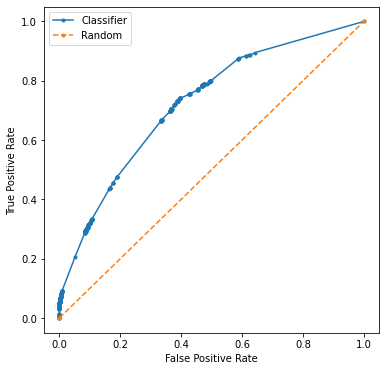

In [204]:
params = {
    'feature_selection': 'RFE_RandomForestClassifier',
    'n_features_to_select': 5,
    'classifier': 'RandomForestClassifier'
}

pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_val, y_val))
plot_metrics(pipe)

0.9084967320261438
Our Model: ROC AUC=0.729


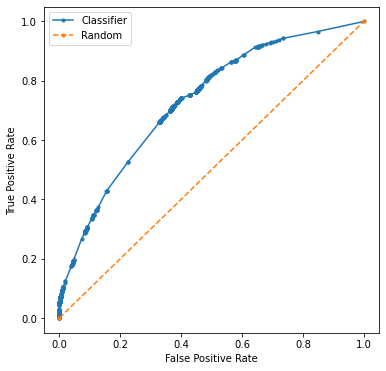

In [205]:
params = {
    'feature_selection': 'RFE_RandomForestClassifier',
    'n_features_to_select': 10,
    'classifier': 'RandomForestClassifier'
}

pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_val, y_val))
plot_metrics(pipe)

0.9084967320261438
Our Model: ROC AUC=0.735


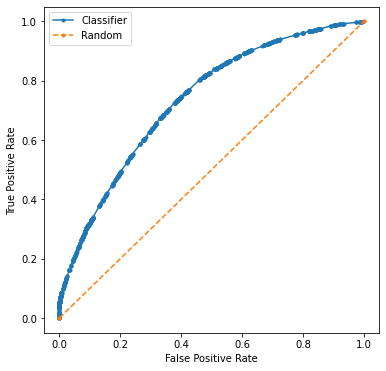

In [206]:
params = {
    'feature_selection': 'RFE_RandomForestClassifier',
    'n_features_to_select': 5,
    'classifier': 'XGBClassifier'
}

pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_val, y_val))
plot_metrics(pipe)

0.9084967320261438
Our Model: ROC AUC=0.742


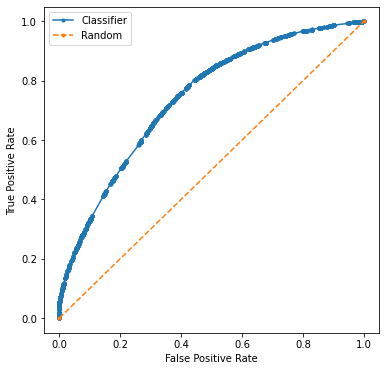

In [207]:
params = {
    'feature_selection': 'RFE_RandomForestClassifier',
    'n_features_to_select': 10,
    'classifier': 'XGBClassifier'
}

pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_val, y_val))
plot_metrics(pipe)

0.9084967320261438
Our Model: ROC AUC=0.747


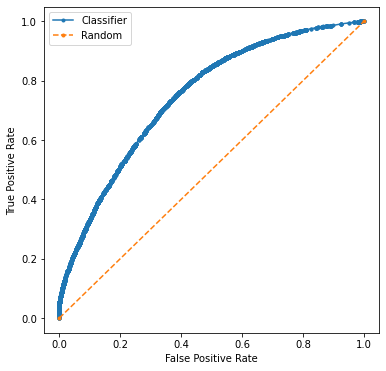

In [208]:
params = {
    'feature_selection': 'RFE_RandomForestClassifier',
    'n_features_to_select': 15,
    'classifier': 'XGBClassifier'
}

pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_val, y_val))
plot_metrics(pipe)

/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:41:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9084967320261438
Our Model: ROC AUC=0.759
Random: ROC AUC=0.500


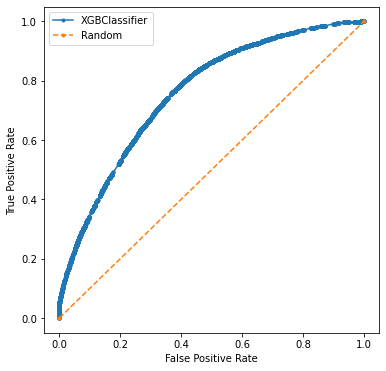

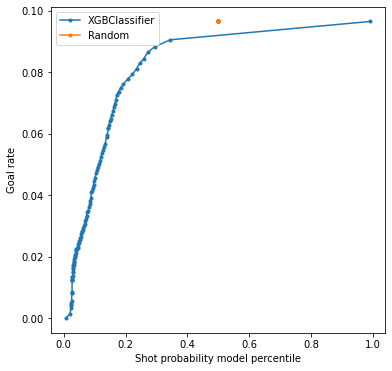

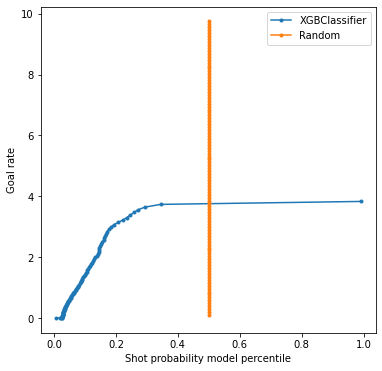

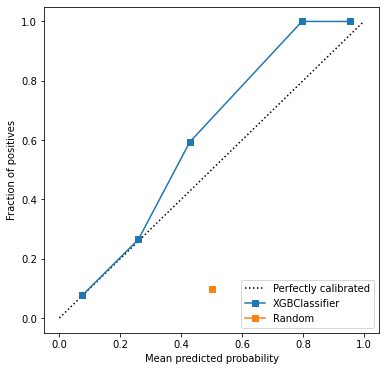

In [90]:
params = {
    'feature_selection': 'RFE_RandomForestClassifier',
    'n_features_to_select': 20,
    'classifier': 'XGBClassifier'
}

pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_val, y_val))
plot_metrics(pipe)

/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8427396307065285
Our Model: ROC AUC=0.640
Random: ROC AUC=0.500


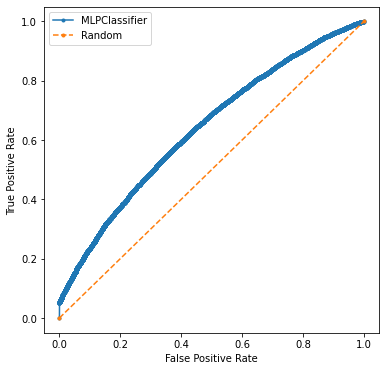

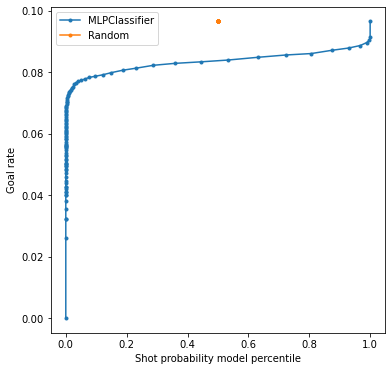

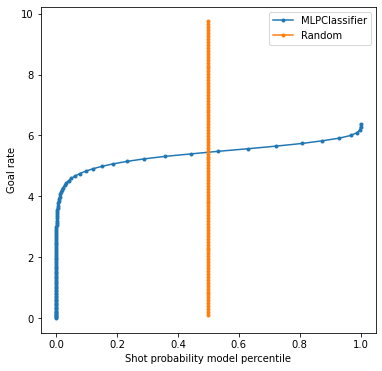

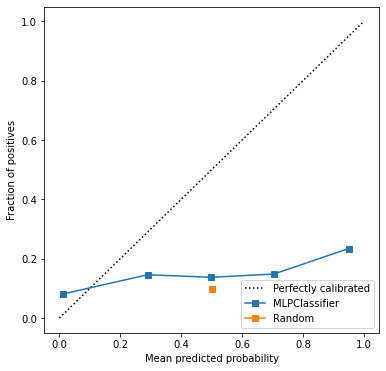

In [94]:
params = {
    'encoder': 'OneHotEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    'n_features_to_select': 20,
    'classifier': 'MLPClassifier'
}

pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_val, y_val))
plot_metrics(pipe)

/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9077636124158155
Our Model: ROC AUC=0.745
Random: ROC AUC=0.500


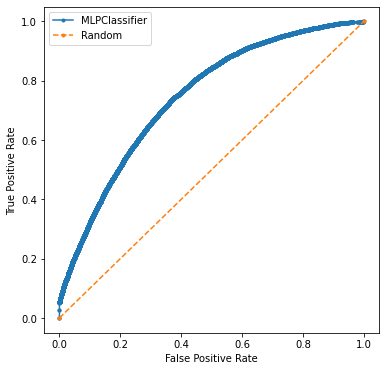

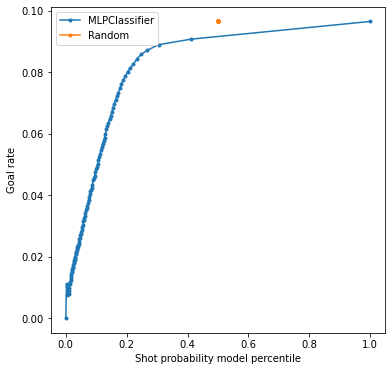

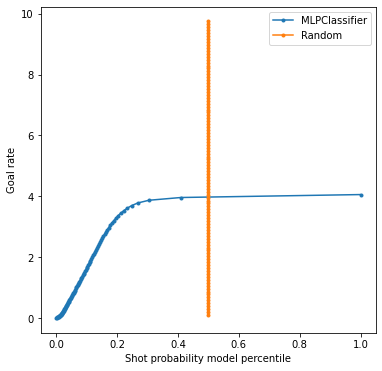

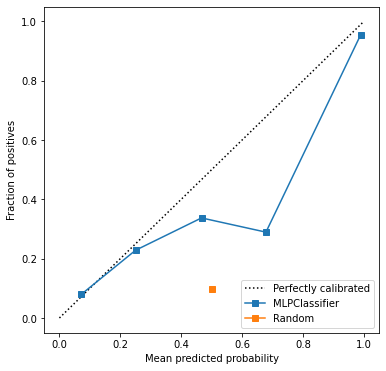

In [96]:
params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    'n_features_to_select': 20,
    'classifier': 'MLPClassifier',
    'hidden_layer_sizes': (100,),
    'early_stopping': True,
}

pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_val, y_val))
plot_metrics(pipe)

/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9079375730013172
Our Model: ROC AUC=0.741
Random: ROC AUC=0.500


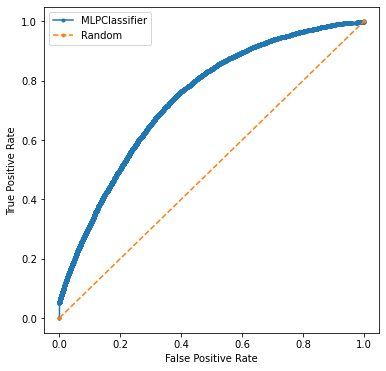

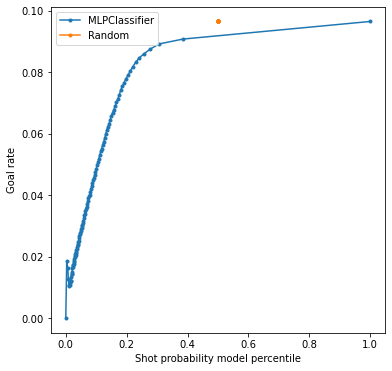

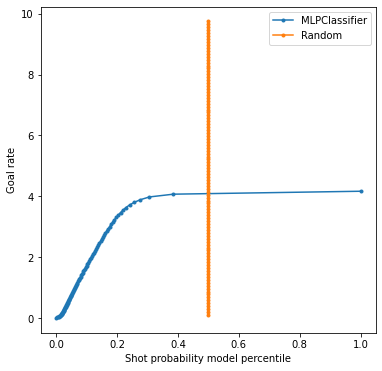

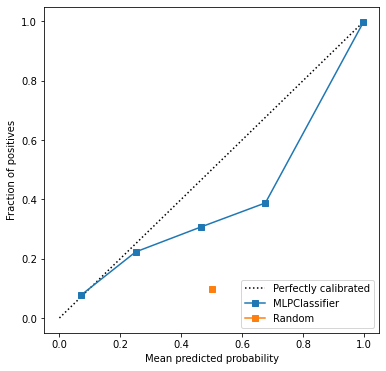

In [97]:
params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    'n_features_to_select': 20,
    'classifier': 'MLPClassifier',
    'hidden_layer_sizes': (50,50),
    'early_stopping': True,
}

pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_val, y_val))
plot_metrics(pipe)

/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9114808262656746 0.908509157782251
Our Model: ROC AUC=0.697
Random: ROC AUC=0.500


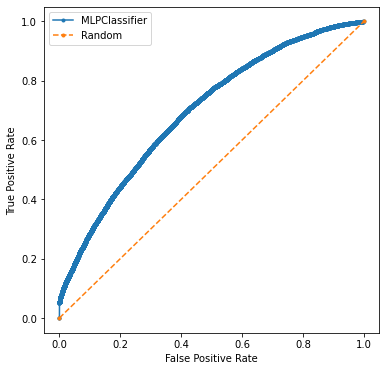

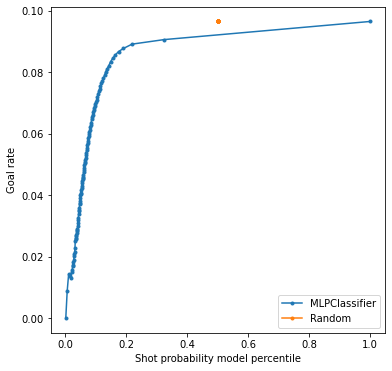

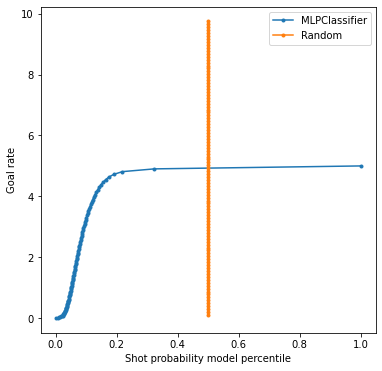

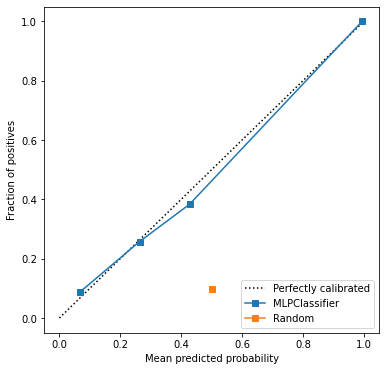

In [12]:
params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    'n_features_to_select': 20,
    'classifier': 'MLPClassifier',
    'hidden_layer_sizes': (50,50,50),
    'early_stopping': True,
}

exp.log_parameters(params)
pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train), pipe.score(X_val, y_val))
exp.log_metric('Train Accuracy', pipe.score(X_train, y_train))
exp.log_metric('Valid Accuracy', pipe.score(X_val, y_val))
plot_metrics(pipe)

COMET WARNING: truncated string; too long: 'ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x180af9f10>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Missing '
                                                                           'Data',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                      

0.908509157782251
Our Model: ROC AUC=0.715
Random: ROC AUC=0.500


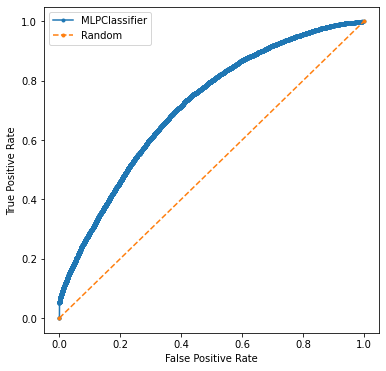

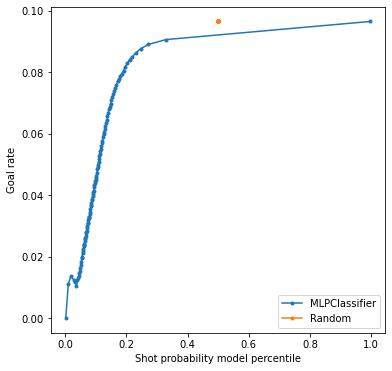

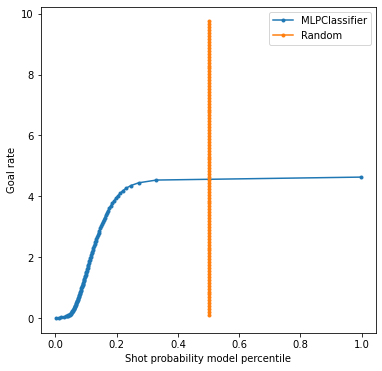

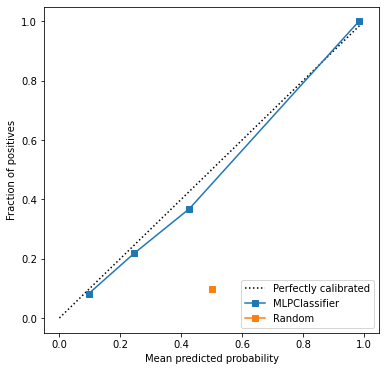

In [9]:
params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    'n_features_to_select': 20,
    'classifier': 'MLPClassifier',
    'hidden_layer_sizes': (100,100,100),
    'early_stopping': True,
}

exp.log_parameters(params)
pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train), pipe.score(X_val, y_val))
exp.log_metric('Train Accuracy', pipe.score(X_train, y_train))
exp.log_metric('Valid Accuracy', pipe.score(X_val, y_val))
plot_metrics(pipe)

/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9112596909308497 0.9079624245135316
Our Model: ROC AUC=0.738
Random: ROC AUC=0.500


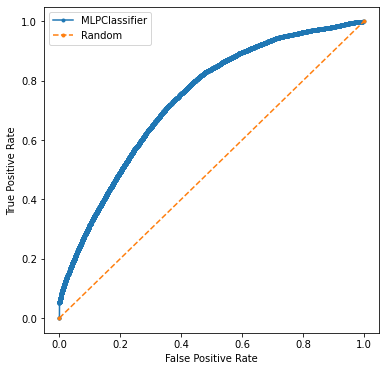

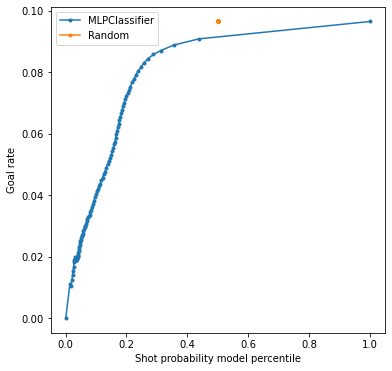

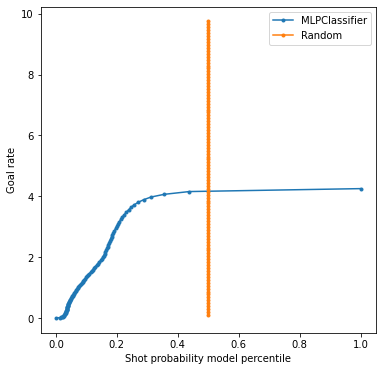

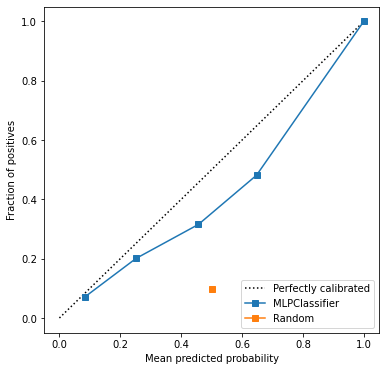

In [13]:
params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    'n_features_to_select': 40,
    'classifier': 'MLPClassifier',
    'hidden_layer_sizes': (100,100,100),
    'early_stopping': True,
}

exp.log_parameters(params)
pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train), pipe.score(X_val, y_val))
exp.log_metric('Train Accuracy', pipe.score(X_train, y_train))
exp.log_metric('Valid Accuracy', pipe.score(X_val, y_val))
plot_metrics(pipe)

/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9115068421874187 0.9083227714406422
Our Model: ROC AUC=0.739
Random: ROC AUC=0.500


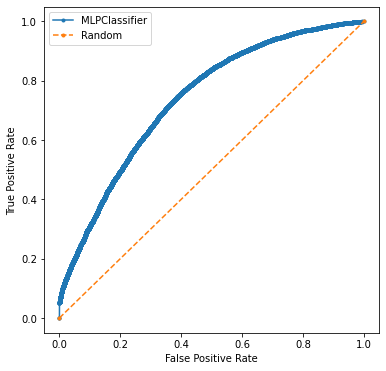

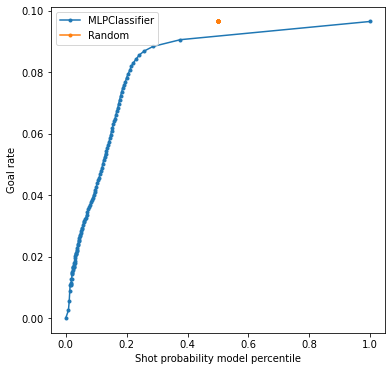

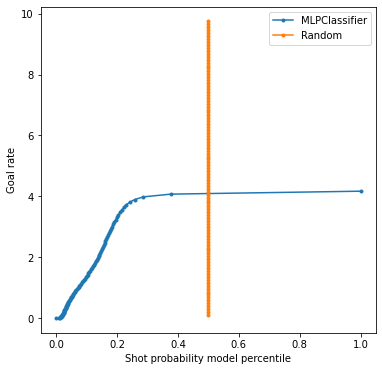

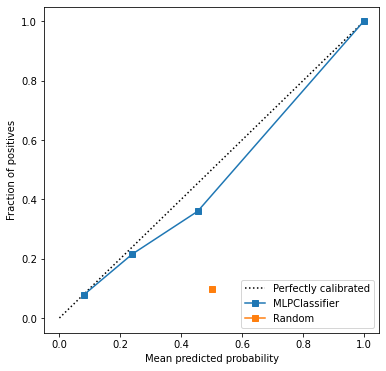

In [14]:
params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    'n_features_to_select': 40,
    'classifier': 'MLPClassifier',
    'hidden_layer_sizes': (100,100,100,100),
    'early_stopping': True,
}

exp.log_parameters(params)
pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train), pipe.score(X_val, y_val))
exp.log_metric('Train Accuracy', pipe.score(X_train, y_train))
exp.log_metric('Valid Accuracy', pipe.score(X_val, y_val))
plot_metrics(pipe)

/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9115241861352481 0.9084221774895003
Our Model: ROC AUC=0.737
Random: ROC AUC=0.500


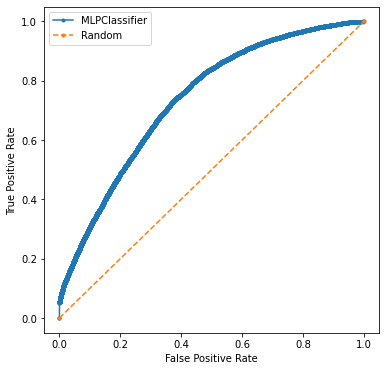

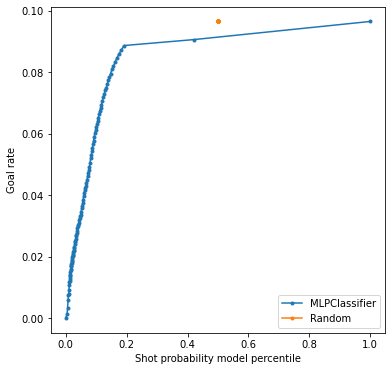

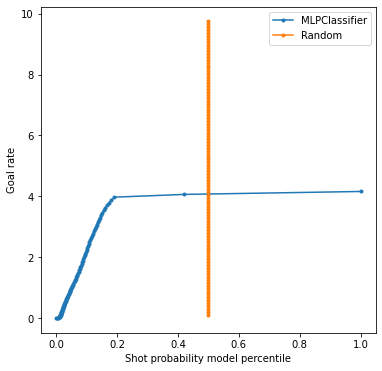

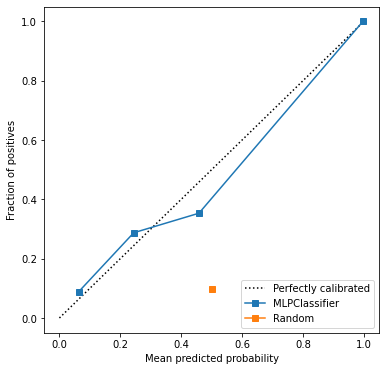

In [15]:
params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    'n_features_to_select': 40,
    'classifier': 'MLPClassifier',
    'hidden_layer_sizes': (200,200,100,100),
    'early_stopping': True,
}

exp.log_parameters(params)
pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train), pipe.score(X_val, y_val))
exp.log_metric('Train Accuracy', pipe.score(X_train, y_train))
exp.log_metric('Valid Accuracy', pipe.score(X_val, y_val))
plot_metrics(pipe)

/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9115068421874187 0.9084967320261438
Our Model: ROC AUC=0.673
Random: ROC AUC=0.500


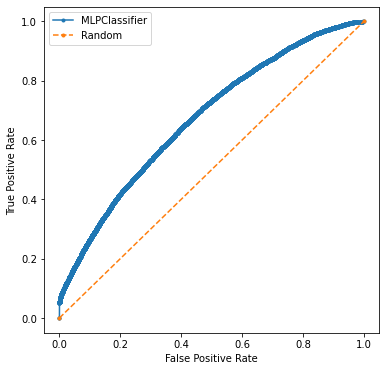

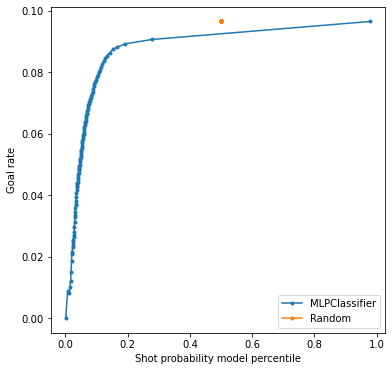

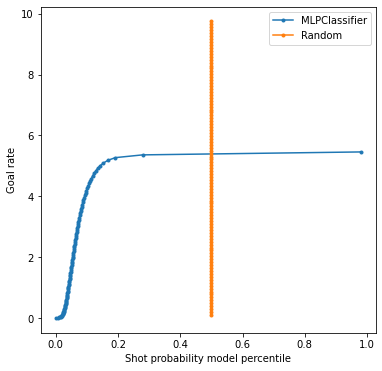

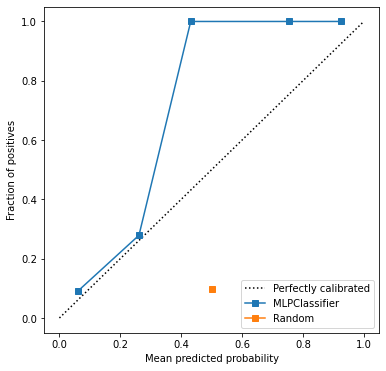

In [16]:
params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    'n_features_to_select': 40,
    'classifier': 'MLPClassifier',
    'hidden_layer_sizes': (200,200,200,200),
    'early_stopping': True,
}

exp.log_parameters(params)
pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train), pipe.score(X_val, y_val))
exp.log_metric('Train Accuracy', pipe.score(X_train, y_train))
exp.log_metric('Valid Accuracy', pipe.score(X_val, y_val))
plot_metrics(pipe)

/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9115241861352481 0.9084967320261438
Our Model: ROC AUC=0.737
Random: ROC AUC=0.500


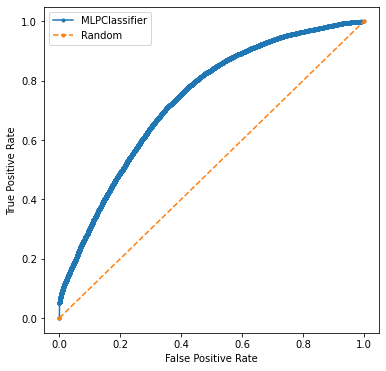

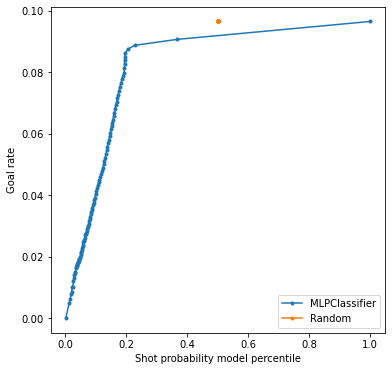

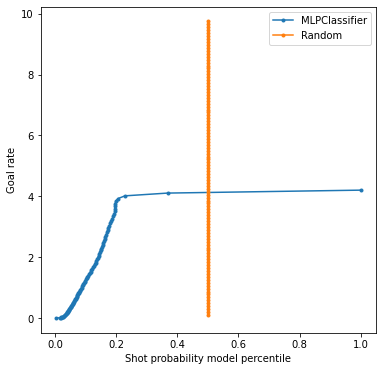

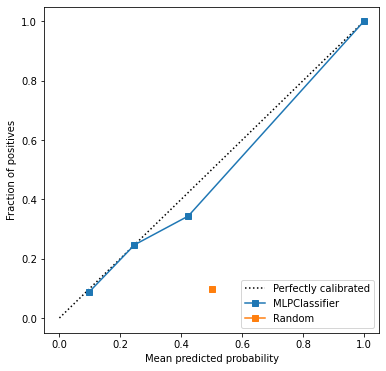

In [17]:
params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    'n_features_to_select': 40,
    'classifier': 'MLPClassifier',
    'hidden_layer_sizes': (400,400,400,200),
    'early_stopping': True,
}

exp.log_parameters(params)
pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train), pipe.score(X_val, y_val))
exp.log_metric('Train Accuracy', pipe.score(X_train, y_train))
exp.log_metric('Valid Accuracy', pipe.score(X_val, y_val))
plot_metrics(pipe)

/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET WARNING: You must 

0.9115155141613334 0.9084843062700365
Our Model: ROC AUC=0.755
Random: ROC AUC=0.500


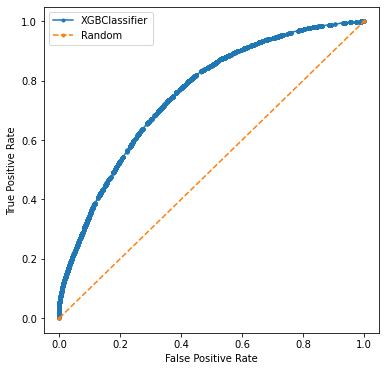

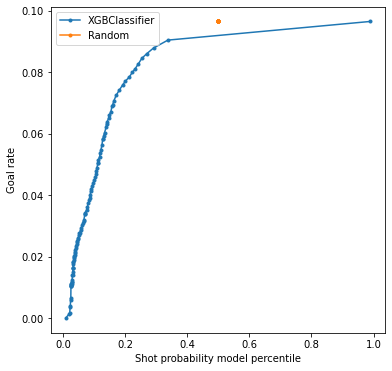

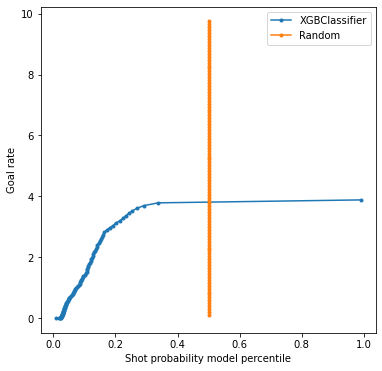

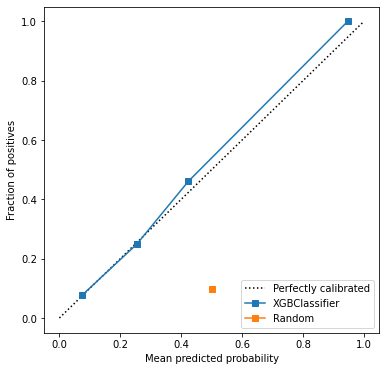

In [19]:
params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    'n_features_to_select': 40,
    'classifier': 'XGBClassifier',
    # 'hidden_layer_sizes': (400,400,400,200),
    # 'early_stopping': True,
}

exp.log_parameters(params)
pipe = create_pipeline(params)
pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train), pipe.score(X_val, y_val))
exp.log_metric('Train Accuracy', pipe.score(X_train, y_train))
exp.log_metric('Valid Accuracy', pipe.score(X_val, y_val))
plot_metrics(pipe)

In [24]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    'n_features_to_select': 40,
    'classifier': 'XGBClassifier',
}

# exp.log_parameters(params)
pipe = create_pipeline(params)

tscv = TimeSeriesSplit()
scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=tscv, n_jobs=-1)
print(scores)
print('Mean ROC AUC: %.5f' % np.mean(scores))
    


/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


0.9109872519334247 0.9085464350505729


/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:20:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:20:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:20:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:20:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:20:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.76173927 0.76635597 0.7624384  0.75565941 0.76120422]
Mean ROC AUC: 0.76148


In [54]:
# from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

init_params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    'n_features_to_select': 3,
    'classifier': 'XGBClassifier',
}
pipe = create_pipeline(init_params)

param_grid = {
    'feature_selection__max_features': [3,5,10,15,20,30,40,50],
    'classifier__max_depth': [1,2,3,4,5,6,7],
    'classifier__n_estimators': [10,20,40,80,120,160,200,240,280,320],
    'classifier__use_label_encoder': [False],
}

tscv = TimeSeriesSplit()
search = RandomizedSearchCV(pipe, param_grid,  cv=tscv, scoring='roc_auc', random_state=0).fit(X, y)
search.best_params_  

/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/usr/local/ana

In [10]:
exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/meriembchaaben/ift6758/40f60ec8dff54d7d86391cd703161bd0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Accuracy [2] : (0.8941822609905813, 0.908509157782251)
COMET INFO:     ROC AUC [3]  : (0.6459401806831893, 0.7148550889267846)
COMET INFO:   Others:
COMET INFO:     dataset_info : [        period periodTime periodType        teamOfShooter homeOrAway  \
0            1      00:51    REGULAR  Toronto Maple Leafs       home   
1            1      01:05    REGULAR  Toronto Maple Leafs       home   
2            1      01:06    REGULAR  Toronto Maple Leafs       home   
3            1      01:53    REGULAR  Toronto Maple Leafs       home   
4            1      02:37    REGULAR  Toronto Maple Leafs       home   
...        ...        ...     

In [ ]:
# Miscellaneous Functions

def convert(time):
    minutes, seconds = time.split(':')
    return 60 * int(minutes) + int(seconds)

# ('feature_selection', SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False))),
# ('feature_selection', SelectFromModel(GaussianNB())),
# ('feature_selection', RFE(GaussianNB(), n_features_to_select=15, step=1)),

# clf = pipe['classifer']
# clf.feature_importances_
# print(np.max(clf.feature_importances_), X_train.columns[np.argmax((clf.feature_importances_))])

# exp.log_metrics({'Dataset size': len(X), 'Training dataset size': len(X_train), 'Validation dataset size': len(X_val)})
# exp.end()